In [1]:
import torch
from PIL import Image

import main
from utils import stitch_images

In [2]:
d = torch.load(main.IMAGE_VECTORS_DICT_FILE)
filenames = d.get('filenames')
image_vectors = d.get('vectors')
len(filenames), image_vectors.shape

(10373, torch.Size([10373, 512]))

In [3]:
norms = image_vectors.norm(dim=-1, keepdim=True)
image_vectors /= norms
image_vectors.shape

torch.Size([10373, 512])

### 1. Create projection matrices for positive and negative prompts

In [4]:
pos_prompt_vectors = torch.cat([
    main.convert_text_to_vector(prompt) for prompt in main.POSITIVE_PROMPTS
], dim=0)

neg_prompt_vectors = torch.cat([
    main.convert_text_to_vector(prompt) for prompt in main.NEGATIVE_PROMPTS
], dim=0)

pos_prompt_vectors.shape, neg_prompt_vectors.shape

(torch.Size([10, 512]), torch.Size([10, 512]))

In [5]:
pos_projection_matrix = main.create_projection_matrix(pos_prompt_vectors.t())
neg_projection_matrix = main.create_projection_matrix(neg_prompt_vectors.t())
pos_projection_matrix.shape, neg_projection_matrix.shape

(torch.Size([512, 512]), torch.Size([512, 512]))

### 2. Find the projections of the image vectors onto the vector subspaces

In [6]:
pos_norms = (image_vectors @ pos_projection_matrix.t()).norm(dim=-1)
neg_norms = (image_vectors @ neg_projection_matrix.t()).norm(dim=-1)
pos_norms.shape, neg_norms.shape

(torch.Size([10373]), torch.Size([10373]))

### 3. Take a weighted sum of the norms of these two projections

In [7]:
w_pos = 1
w_neg = -1
score = w_pos * pos_norms + w_neg * neg_norms

### 4. Sort by scores

In [8]:
sorted_indices = torch.argsort(score, descending=True)

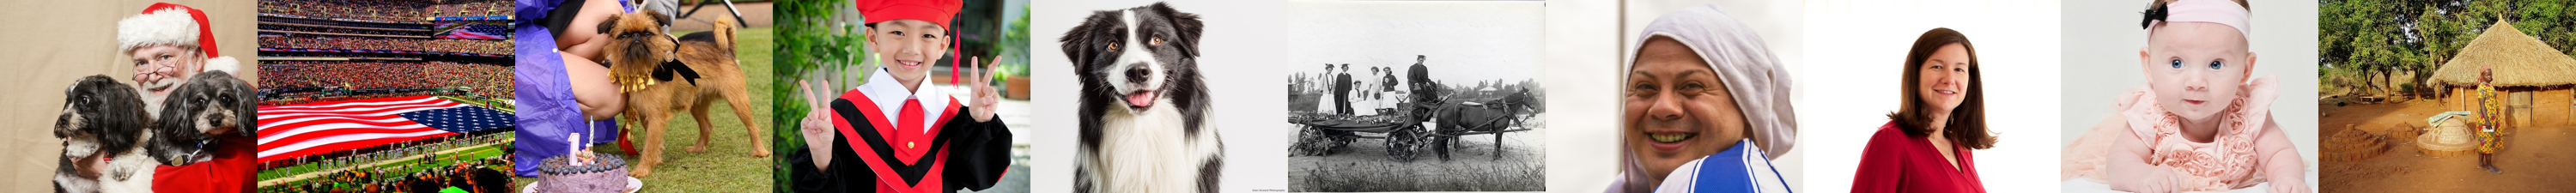

In [9]:
top_10_images = [Image.open(filenames[sorted_indices[i]]) for i in range(10)]
stitch_images(top_10_images)

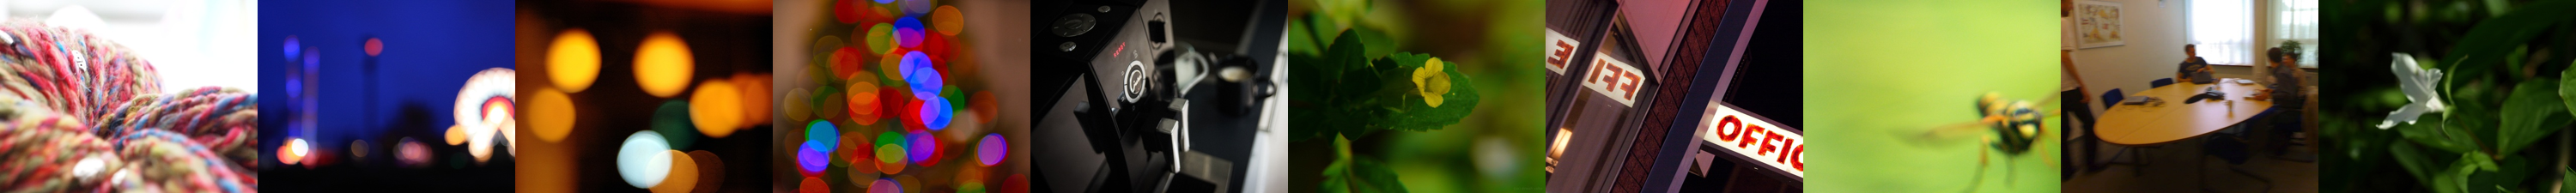

In [10]:
bottom_10_images = [Image.open(filenames[sorted_indices[-i]]) for i in range(1,11)]
stitch_images(bottom_10_images)